# Simulation

## System description

Here we simulate an *inverted pendulum on a cart* (based on [this example](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)).  

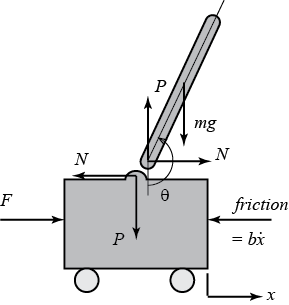

Given a state vector  

$$
\zeta = [x, \dot{x}, \theta, \dot{\theta}]^\top,
$$

where:
- $x$ is the **cart position**,
- $\dot{x}$ is the **cart velocity**,
- $\theta$ is the **pendulum angle** (measured from the upright vertical),
- $\dot{\theta}$ is the **angular velocity** of the pendulum,  

this system can be described by the following ordinary differential equations:

$$
\ddot{x} = \frac{F + m \sin\theta \left(l \dot{\theta}^2 + g \cos\theta \right)}{M + m \sin^2\theta},
$$

$$
\ddot{\theta} = \frac{-F \cos\theta - m l \dot{\theta}^2 \cos\theta \sin\theta - (M + m) g \sin\theta}{l (M + m \sin^2\theta)}.
$$

Here:
- $m$ is the **mass of the pendulum**,
- $M$ is the **mass of the cart**,
- $l$ is the **length from the pivot to the center of mass of the pendulum**,
- $g$ is the **gravitational acceleration**,
- $F$ is the **input force applied to the cart**.

This system is naturally **unstable**, meaning that without control, the pendulum will fall unless perfectly balanced.  

## Control Strategy
This system can be stabilized by a **Proportional-Derivative (PD) controller**, which applies a control force based on the pendulum's angle and angular velocity:

$$
F = K_p \theta + K_d \dot{\theta}
$$

where:
- $K_p$ is the **proportional gain**, which counteracts deviations from the upright position,
- $K_d$ is the **derivative gain**, which damps oscillations by reacting to the angular velocity.

By choosing appropriate values for $K_p$ and $K_d$, the controller ensures that the pendulum returns to its upright position smoothly while minimizing overshoot and oscillations.
<code> 

</code>

# Simulation Example
The following is an implementation of a simulation with a PD controller for an instance of the inverted pendulum system.

### Imports & Function Definitions

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.patches import Rectangle

def pendulum_dynamics(state, t, M, m, l, g, Kp, Kd):
    """ Computes state derivatives for the inverted pendulum on a cart with PD control. """
    x, x_dot, theta, theta_dot = state
    F = Kp*theta + Kd*theta_dot  # PD control force

    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    denom = M + m*sin_theta**2

    # Equations of motion
    x_ddot = (F + m*sin_theta*(l*theta_dot**2 + g*cos_theta))/denom
    theta_ddot = (-F*cos_theta - m*l*theta_dot**2*cos_theta*sin_theta - (M + m)*g*sin_theta)/(l*denom)

    return [x_dot, x_ddot, theta_dot, theta_ddot]

def simulate_pendulum(Kp=100.0, Kd=20.0, T=10, dt=0.01):
    """ Simulates the inverted pendulum system. """
    state0 = [0.0, 0.0, 0.1, 0.0]  # Initial state
    t = np.arange(0, T, dt)  # Time vector
    sol = odeint(pendulum_dynamics, state0, t, args=(M, m, l, g, Kp, Kd))
    return t, sol

def animate_pendulum(sol, t):
    """ Creates an animation of the inverted pendulum system. """
    x = sol[:, 0]
    theta = sol[:, 2]
    theta_dot = sol[:, 3]

    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.5, 1, 1])
    ax_anim = fig.add_subplot(gs[0])
    ax_ts = fig.add_subplot(gs[1])
    ax_phase = fig.add_subplot(gs[2])

    # --- Animation Plot ---
    ax_anim.set_xlim(min(x)-0.5, max(x)+0.5)
    ax_anim.set_ylim(-0.5, l+0.8)
    ax_anim.set_aspect('equal')
    ax_anim.grid(True)
    ax_anim.set_title('Animation')

    # Ground line
    ax_anim.plot([min(x)-1, max(x)+1], [0, 0], 'k-', lw=2)

    # Cart setup
    cart_width, cart_height = 0.4, 0.2
    cart = Rectangle((x[0]-cart_width/2, 0), cart_width, cart_height, fc='blue', ec='black')
    ax_anim.add_patch(cart)

    # Pendulum
    pendulum_line, = ax_anim.plot([], [], 'o-', lw=3, color='red')

    # --- Time Series Plot ---
    ax_ts.set_xlim(t[0], t[-1])
    ax_ts.set_ylim(min(np.min(x), np.min(theta)) - 0.2, max(np.max(x), np.max(theta)) + 0.2)
    ax_ts.set_title('Time Series')
    ax_ts.set_xlabel('Time [s]')
    ax_ts.grid(True)
    line_x, = ax_ts.plot([], [], 'b-', lw=2, label='Cart Position x')
    line_theta, = ax_ts.plot([], [], 'r-', lw=2, label='Pendulum Angle θ')
    ax_ts.legend(loc='upper right')
    time_marker = ax_ts.axvline(t[0], color='k', ls='--')

    # --- Phase Plot ---
    ax_phase.set_xlim(np.min(theta)-0.1, np.max(theta)+0.1)
    ax_phase.set_ylim(np.min(theta_dot)-0.1, np.max(theta_dot)+0.1)
    ax_phase.set_title('Phase Plot (θ vs. θ̇)')
    ax_phase.set_xlabel('Pendulum Angle θ [rad]')
    ax_phase.set_ylabel('Angular Velocity θ̇ [rad/s]')
    ax_phase.grid(True)
    phase_line, = ax_phase.plot([], [], 'm-', lw=2)

    # --- Animation Functions ---
    def init():
        cart.set_xy((x[0]-cart_width/2, 0))
        pendulum_line.set_data([], [])
        line_x.set_data([], [])
        line_theta.set_data([], [])
        phase_line.set_data([], [])
        time_marker.set_xdata([t[0], t[0]])
        return cart, pendulum_line, line_x, line_theta, phase_line, time_marker

    def update(i):
        cart.set_xy((x[i]-cart_width/2, 0))
        pivot = (x[i], cart_height)
        pendulum_x = pivot[0] + l * np.sin(theta[i])
        pendulum_y = pivot[1] + l * np.cos(theta[i])
        pendulum_line.set_data([pivot[0], pendulum_x], [pivot[1], pendulum_y])

        # Time Series
        line_x.set_data(t[:i+1], x[:i+1])
        line_theta.set_data(t[:i+1], theta[:i+1])
        time_marker.set_xdata([t[i], t[i]])

        # Phase Plot
        phase_line.set_data(theta[:i+1], theta_dot[:i+1])
        return cart, pendulum_line, line_x, line_theta, phase_line, time_marker

    ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init,
                                  blit=True, interval=30, repeat=True)
    plt.tight_layout()
    plt.close()
    return HTML(ani.to_jshtml())


### System Simulation

In [ ]:
# Physical parameters for the inverted pendulum on a cart
M = 1.0    # mass of the cart (kg)
m = 0.1    # mass of the pendulum (kg)
l = 0.5    # length to pendulum center of mass (m)
g = 9.81   # gravitational acceleration (m/s^2)

# Control parameters
Kp, Kd = 100.0, 20.0  # PD controller gains

# Simulation setup
T = 10                # Total simulation time
dt = 0.01             # Time step

# Simulation
t, sol = simulate_pendulum(Kp, Kd, T, dt)

### Animation

In [ ]:
# Downsample data for animation (reduce memory usage)
frame_step = 5  # Keep every 5th frame
t_anim = t[::frame_step]
sol_anim = sol[::frame_step]

In [ ]:
# from ipysim.core import Simulator
# from ipysim.widgets import Slider# Run animation
# animate_pendulum(sol_anim, t_anim)

# from ipysim.core import Simulator
# from ipysim.widgets import Slider
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# def run_pendulum_sim(Kp, Kd):
#     t_anim, sol_anim = simulate_pendulum(Kp, Kd)
#     assert sol.ndim == 2, f"Expected a 2D array, but got {sol.shape}"
#     return animate_pendulum(sol_anim, t_anim)

# sim = Simulator(run_pendulum_sim)
# sim.add_widget(Slider("Kp", min=0, max=50, step=1, default=0))
# sim.add_widget(Slider("Kd", min=0, max=10, step=0.5, default=0))

# sim.display()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# function to update plot
def update_plot(freq=1.0):
    x = np.linspace(0, 10, 100)
    y = np.sin(freq * x)
    
    plt.figure(figsize=(5,3))
    plt.plot(x, y)
    plt.title(f"sin({freq} * x)")
    plt.show()

# create an interactive slider
slider = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1.0, description="Frequency")
widgets.interactive(update_plot, freq=slider)


In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipysim.core.dynamics import pendulum_dynamics
from ipysim.core.integrators import simulate
from ipysim.core.parameters import PendulumParams
from ipysim.interactive.sliders import generate_sliders
from ipysim.visualization.animation import animate_system
from ipysim.visualization.plotting import plot_simulation

# Define initial conditions
initial_state = [0.0, 0.0, 0.1, 0.0]  # [x, x_dot, theta, theta_dot]
t_span = np.linspace(0, 10, 500)  # Time vector

# Define sliders for user input
slider_specs = [
    {"name": "M", "min": 0.5, "max": 2.0, "step": 0.1, "default": 1.0},
    {"name": "m", "min": 0.05, "max": 0.5, "step": 0.05, "default": 0.1},
    {"name": "l", "min": 0.2, "max": 1.0, "step": 0.1, "default": 0.5},
    {"name": "Kp", "min": 50, "max": 200, "step": 10, "default": 100},
    {"name": "Kd", "min": 10, "max": 50, "step": 5, "default": 20},
]

sliders = generate_sliders(slider_specs)
ui = widgets.VBox(list(sliders.values()))
display(ui)

# Function to update the simulation with new parameters
def run_simulation(M, m, l, Kp, Kd):
    """
    Runs the simulation and visualizes it with time series, phase plot, and animation.
    """
    params = PendulumParams(M=M, m=m, l=l, Kp=Kp, Kd=Kd)
    solution = simulate(pendulum_dynamics, initial_state, t_span, params)

    # Plot time series and phase plot
    plot_simulation(
        t_span, solution,
        labels=["Cart Position x", "Cart Velocity", "Pendulum Angle θ", "Angular Velocity θ̇"]
    )

    # Animate the system
    display(animate_system(solution, t_span))


# Connect sliders to simulation function
widgets.interactive_output(run_simulation, sliders)
